In [1]:
import numpy as np
import cv2

def gaussian(t,sig):
	return (1/np.sqrt(2*np.pi*sig))*np.exp(-t**2/(2*sig**2))

def flowNeighbour(angle):
    angles = np.array([0, 45, 90, 135, 180, 225, 270, 315])
    pairs = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]

    angle_diff = np.abs(angles - angle[:, :, np.newaxis])
    ind = np.argmin(angle_diff, axis=-1)

    return np.array(pairs)[ind]

def vectorAngle(x, y):
    zero_mask = x == 0
    res = np.arctan(np.abs(y) / np.abs(x))
    
    res = np.where(zero_mask, np.pi / 2, res)
    res = np.where((x >= 0) & (y >= 0), 2 * np.pi - res, res)
    res = np.where((x >= 0) & (y < 0), res, res)
    res = np.where((x < 0) & (y >= 0), np.pi + res, res)
    res = np.where((x < 0) & (y < 0), np.pi - res, res)
    
    return res

def laplacian(t,sigc,p):
	sigs = 1.05 * sigc
	return gaussian(t,sigc) - p*gaussian(t,sigs)


In [2]:
import cv2
import numpy as np
from numpy import linalg as LA
#import lic_internal
import pylab as plt
import time
# from utils import *

def ETF(gray_image, iterations, mu, type):
	gray_image = np.divide(gray_image, 255.0)

	# Here, the Sobel operator is used to compute the gradient of the input grayscale image in the x and y directions. 
	# The magnitude of the gradient is normalized to the range [0, 1]. 
	sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
	sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
	sobelmag = np.sqrt(np.multiply(sobelx, sobelx) + np.multiply(sobely, sobely))
	sobelm = np.divide(sobelmag, np.amax(sobelmag))
	

	# Tangent vectors are initialized perpendicular to the gradient direction.
	tangx = -1 * sobely
	tangy = sobelx
	tang = np.stack([tangx, tangy], axis=2)
	size = tang.shape
	
	# The tangent vectors are normalized to have unit magnitude.
	tangnorm = LA.norm(tang, axis=2)
	np.place(tangnorm, tangnorm == 0, [1])
	tang = np.divide(tang, np.stack([tangnorm, tangnorm], axis=2))

	# Applying ETF for a specific number of iterations
	for iteration in range(iterations):
		start = time.time()
		tang_horz = np.zeros(size)

		for h in range(size[0]):
			for w in range(size[1]):
				total_weight = 0.0
				for j in range(max(0, w-mu), min(size[1], w+mu+1)):
					weight = ((sobelm[h][w]-sobelm[h][j]+1)*np.dot(tang[h][w], tang[h][j]))/2.0
					total_weight += weight
					tang_horz[h][w] += tang[h][j]*weight
				if(total_weight != 0):
					tang_horz[h][w] /= total_weight

		tang = np.zeros(size)

		for h in range(size[0]):
			for w in range(size[1]):
				total_weight = 0.0
				for i in range(max(0, h-mu), min(size[0], h+mu+1)):
					weight = ((sobelm[h][w]-sobelm[i][w]+1)*np.dot(tang_horz[h][w], tang_horz[i][w]))/2.0
					total_weight += weight
					tang[h][w] += tang_horz[i][w]*weight
				if(total_weight != 0):
					tang[h][w] /= total_weight

	tangnorm = LA.norm(tang, axis=2)
	np.place(tangnorm, tangnorm == 0, [1])
	tang = np.divide(tang, np.stack([tangnorm, tangnorm], axis=2))

	return tang

In [52]:
def FDoG_helper(img, etf, p, sigma_c=0.1, sigma_s=20.0):
    size = img.shape
    H2 = img.copy()
    H1 = np.zeros(size)

    # create an array angles to find all the vector angles of etf
    angles = (vectorAngle(etf[:, :, 0], etf[:, :, 1]) + np.pi / 2) % 2*np.pi

    # finding neighbouring flow pixel
    pix = flowNeighbour(angles * 180 / np.pi)

    h, w = np.indices(size)
    # print(w)

    # print(h.shape, w.shape, pix.shape, angles.shape)

    # pix_reshaped = pix[:,np.newaxis, np.newaxis, :, :]

    # print(pix[:,:,0].shape)
    # print(np.arange(-3, 4).shape)

    # Iterate over the range of values
    for j in range(-3, 4):
        # Calculate the shifted indices
        shifted_h_indices = h + pix[:,:,0] * j
        shifted_w_indices = w + pix[:,:,1] * j

        # Check if the shifted indices are within bounds
        valid_indices = (
            (shifted_h_indices >= 0) &(shifted_h_indices < size[0]) & 
            (shifted_w_indices >= 0) & 
            (shifted_w_indices < size[1])
        )

        # Use the valid indices to update H1 based on your condition
        # weight = gaussian(abs(j), 100.0)
        # H1[valid_indices] += H2[shifted_h_indices[valid_indices], shifted_w_indices[valid_indices]] * weight
        H1[valid_indices] += H2[shifted_h_indices[valid_indices], shifted_w_indices[valid_indices]] * laplacian(abs(j), sigma_c, p)
    
    # total_weight_H1 = np.sum(gaussian(np.arange(-3, 4), 10.0))
    # H1 /= total_weight_H1

    # print("H1 size: ", H1.shape)
    H2 = np.zeros(size)

    for j in range(-3, 4):
        # Calculate the shifted indices
        shifted_h_indices = h + pix[:,:,0] * j
        shifted_w_indices = w + pix[:,:,1] * j

        # Check if the shifted indices are within bounds
        valid_indices = (
            (shifted_h_indices >= 0) & 
            (shifted_h_indices < size[0]) & 
            (shifted_w_indices >= 0) & 
            (shifted_w_indices < size[1])
            )

        # Use the valid indices to update H1 based on your condition
        weight = gaussian(abs(j), sigma_s)
        H2[valid_indices] += H1[shifted_h_indices[valid_indices], shifted_w_indices[valid_indices]] * weight

    # normalize H2  
    total_weight = np.sum(gaussian(np.arange(-3, 4), sigma_s)) # absolute?
    H2 /= total_weight
    return H2

def FDoG(img, etf, p, sigma_c, sigma_s, iter):
    matrix = FDoG_helper(img, etf, p, sigma_c, sigma_s)
    # thresholding
    mask1 = (matrix < 0).astype(int)
    mask2 = ((1 + np.tanh(matrix)) < 0.999).astype(int)

    edges = (1 - mask1 * mask2)*255
    edgeImg = np.minimum(edges, img)

    for i in range(iter-1):
        edges = FDoG_helper(edgeImg, etf, p, sigma_c, sigma_s)
        mask1 = (edges < 0).astype(int)
        mask2 = ((1 + np.tanh(edges)) < 0.999).astype(int)
        edges = (1 - mask1 * mask2)*255
        edgeImg = np.minimum(edges, img)

    return edges, edgeImg, matrix


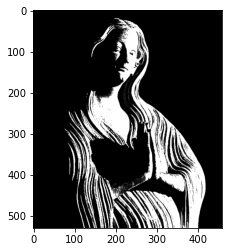

In [64]:
import cv2
import matplotlib.pyplot as plt

# Load an example image (replace 'your_image_path' with the path to your image)
image_path = './image/Extra/woodcut_xdog2.png'
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# resize image
gray_image = cv2.resize(gray_image, (460,530))

# plot resied image
plt.imshow(gray_image, cmap='gray')
plt.show()

# Compute the ETF
etf = ETF(gray_image, iterations=10, mu=3, type=0)

In [79]:
# Call the FDoG function
edges, modified_image, H2 = FDoG(gray_image, etf, p=0.01, sigma_c=0.1, sigma_s=1.1, iter=10)

C:\Users\anjal\AppData\Local\Temp\ipykernel_19588\3786633543.py:18: RuntimeWarning: invalid value encountered in divide
  res = np.arctan(np.abs(y) / np.abs(x))


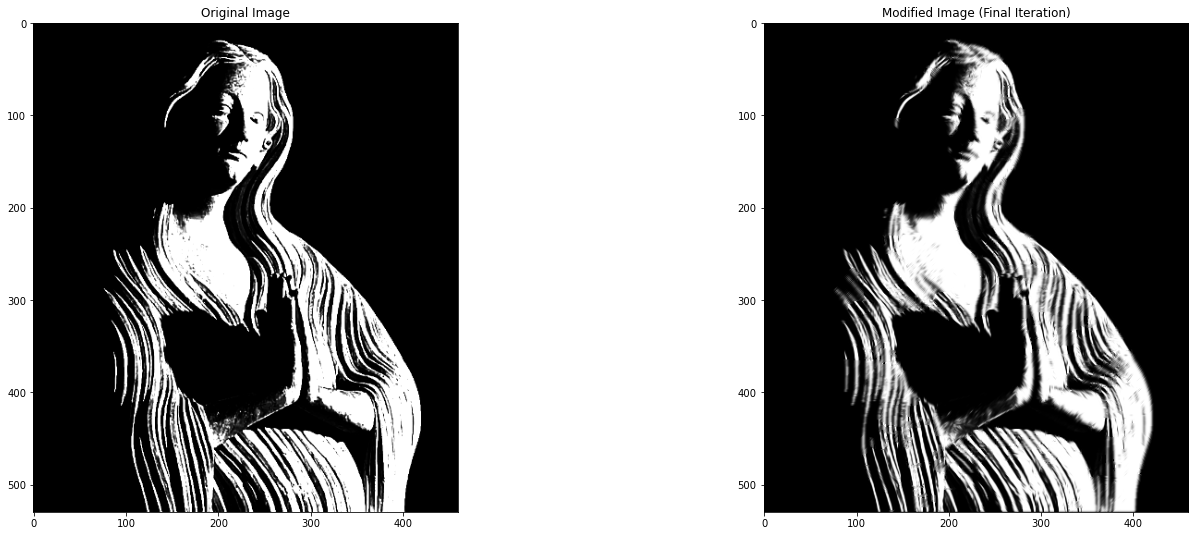

True

In [80]:
# Visualize the results
plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')

# make H2 map to 0 to 255
H2_norm = H2.copy()
H2_norm -= np.min(H2_norm)
H2_norm /= np.max(H2_norm)
H2_norm *= 255
H2_norm = H2_norm.astype(np.uint8)

plt.subplot(122)
plt.imshow(H2_norm, cmap='gray')
plt.title('Modified Image (Final Iteration)')
plt.show()

# save H2 image
cv2.imwrite('./image/fdog/car2_H2.png', H2_norm)

# Bilateral Filter Abstraction